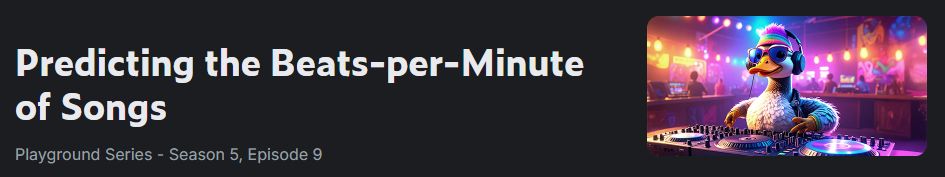
* https://www.kaggle.com/competitions/playground-series-s5e9
* 위 공모전의 목표: 주어진 노래의 여러 특징(feature)들을 기반으로 해당 곡의 BPM(박자 수) 을 예측하는 것

In [125]:
# 파이썬 기본 라이브러리
import math
import warnings

# 데이터 분석 및 시각화 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 주피터 노트북 환경 설정용
from IPython.display import display, HTML

# Scikit-learn (머신러닝) 라이브러리
import sklearn

# 데이터 분할 및 교차 검증
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_validate,
    GridSearchCV,
)

# 회귀 모델 (선형, 트리, 앙상블, SVM)
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    StackingRegressor,
    GradientBoostingRegressor,
    IsolationForest
)
from sklearn.svm import SVR

# 데이터 전처리 및 특성 공학 (스케일러, 변환)
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    FunctionTransformer,
    PowerTransformer
)

# 파이프라인 및 특성 선택
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

# 타깃 변수 변환
from sklearn.compose import TransformedTargetRegressor

# 모델 평가 지표
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
)

# 부스팅 계열 모델 (XGBoost, LightGBM, ...)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor

# 실행 환경 설정: 경고 메시지 무시
warnings.filterwarnings(action='ignore')

# 시각화 기본 스타일 설정 (Seaborn)
sns.set()

# 시각화 한글 폰트 및 마이너스 부호 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 주피터 노트북 셀 너비 확장
display(HTML("<style>.container{width:100% !important;}</style>"))

# Pandas 데이터프레임 출력 옵션 설정
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)
pd.set_option('display.precision', 11)

# Data Load

In [42]:
df = pd.read_csv('../data/train.csv')
df.head()

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


# EDA

| 약어 (Abbr.) | 전체 이름 (Full Name)           | 한 줄 요약 설명 |
|:-------------:|:--------------------------------:|:----------------|
| <font color=yellow>---</font> | <font color=yellow>기본 피쳐</font> | <font color=yellow>---</font> |
| **rs**  | RhythmScore | 리듬의 복잡성이나 규칙성을 나타내는 점수 |
| **al**  | AudioLoudness | 노래의 전체적인 평균 음량 (데시벨) |
| **vc**  | VocalContent | 노래에서 보컬(목소리)이 차지하는 비중 |
| **aq**  | AcousticQuality | 음악이 얼마나 '어쿠스틱'한지(전자음이 적은지) 나타내는 척도 |
| **is**  | InstrumentalScore | 노래에서 악기 연주가 차지하는 비중 |
| **lpl** | LivePerformanceLikelihood | 이 곡이 라이브 공연일 가능성 |
| **ms**  | MoodScore | 곡의 전반적인 분위기(예: 긍정, 부정)를 나타내는 점수 |
| **tdm** | TrackDurationMs | 노래의 총 길이 (밀리초 단위) |
| **e**   | Energy | 노래의 에너지 레벨, 즉 강렬하고 활기찬 정도 |
| **bpm** | BeatsPerMinute | (타겟 변수) 1분당 비트 수, 즉 노래의 빠르기 |
| <font color=yellow>---</font> | <font color=yellow>파생 피쳐</font> | <font color=yellow>---</font> |
| **tdn** | TrackDurationMin | tdm(밀리초)을 분(minute) 단위로 변환한 노래의 길이 |
| **ear** | Energy_Acoustic_Ratio | 에너지 대비 어쿠스틱함의 비율로, 전자음악/어쿠스틱 성향을 나타냄 |
| **vib** | Vocal_Instrument_Balance | 보컬과 악기 사운드의 균형을 나타내는 지표 |
| **mr**  | MoodRhythm | 분위기(Mood)와 리듬감(Rhythm)의 시너지 효과를 나타내는 점수 |
| **pi**  | PerformanceIntensity | 라이브 공연의 강렬함 또는 현장감을 나타내는 지표 |
| **re**  | RhythmEnergy | 리듬의 활기 또는 댄스 가능성을 나타내는 에너지 점수 |
| **ma**  | MoodAcoustic | 음악의 분위기와 어쿠스틱 특성의 조합을 나타내는 값 |

* 학습에 필요없는 id 컬럼 드랍
* 컬럼명 변경

In [43]:
df = df.drop('id', axis=1)
df.columns = ['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e', 'bpm']
df.head()

,rs,al,vc,aq,is,lpl,ms,tdm,e,bpm
0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


* 결측 없고 다 수치형

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   rs      524164 non-null  float64
 1   al      524164 non-null  float64
 2   vc      524164 non-null  float64
 3   aq      524164 non-null  float64
 4   is      524164 non-null  float64
 5   lpl     524164 non-null  float64
 6   ms      524164 non-null  float64
 7   tdm     524164 non-null  float64
 8   e       524164 non-null  float64
 9   bpm     524164 non-null  float64
dtypes: float64(10)
memory usage: 40.0 MB


* 히스토그램
* 오른쪽으로 치우치고(왜도 > 0) 매우 뾰족한(첨도 > 3) 분포: vc, aq, is, lpl
* 왼쪽으로 살짝 치우친(왜도 < 0) 분포: al
* ms의 중간값이 비어 보이는 건 음악의 분위기가 어중간하기보다 확실히 밝거나 확실히 어둡다는 특성을 보여주는 결과
* ms는 데이터에 오류가 있다기보다는, 음악 자체가 가진 본질적인 특성일 가능성이 매우 높음

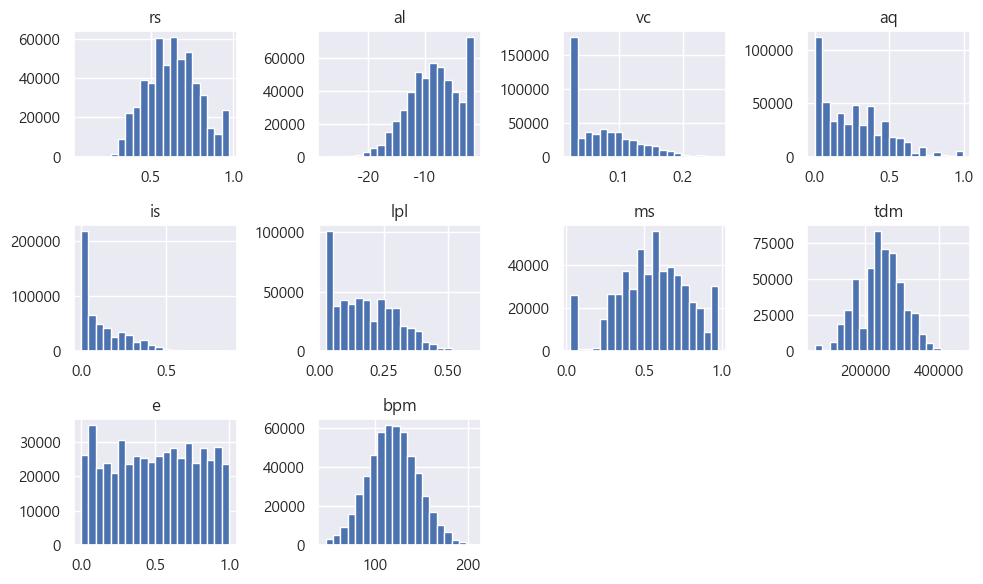

In [45]:
df.hist(figsize=(10, 6), bins=20, layout=(3, 4))
plt.tight_layout()
plt.show()

* 오른쪽으로 심하게 치우친 변수들 (vc, aq, is, lpl, tdm)
* 이 피쳐들은 대부분의 값이 낮은 쪽에 몰려있고, 아웃라이어가 많이 존재
* 왼쪽으로 치우친 변수들 (rs, al, tdm)
* 이 피쳐들은 반대로 대부분의 값이 높은 쪽에 몰려있고, 아웃라이어가 일부 존재

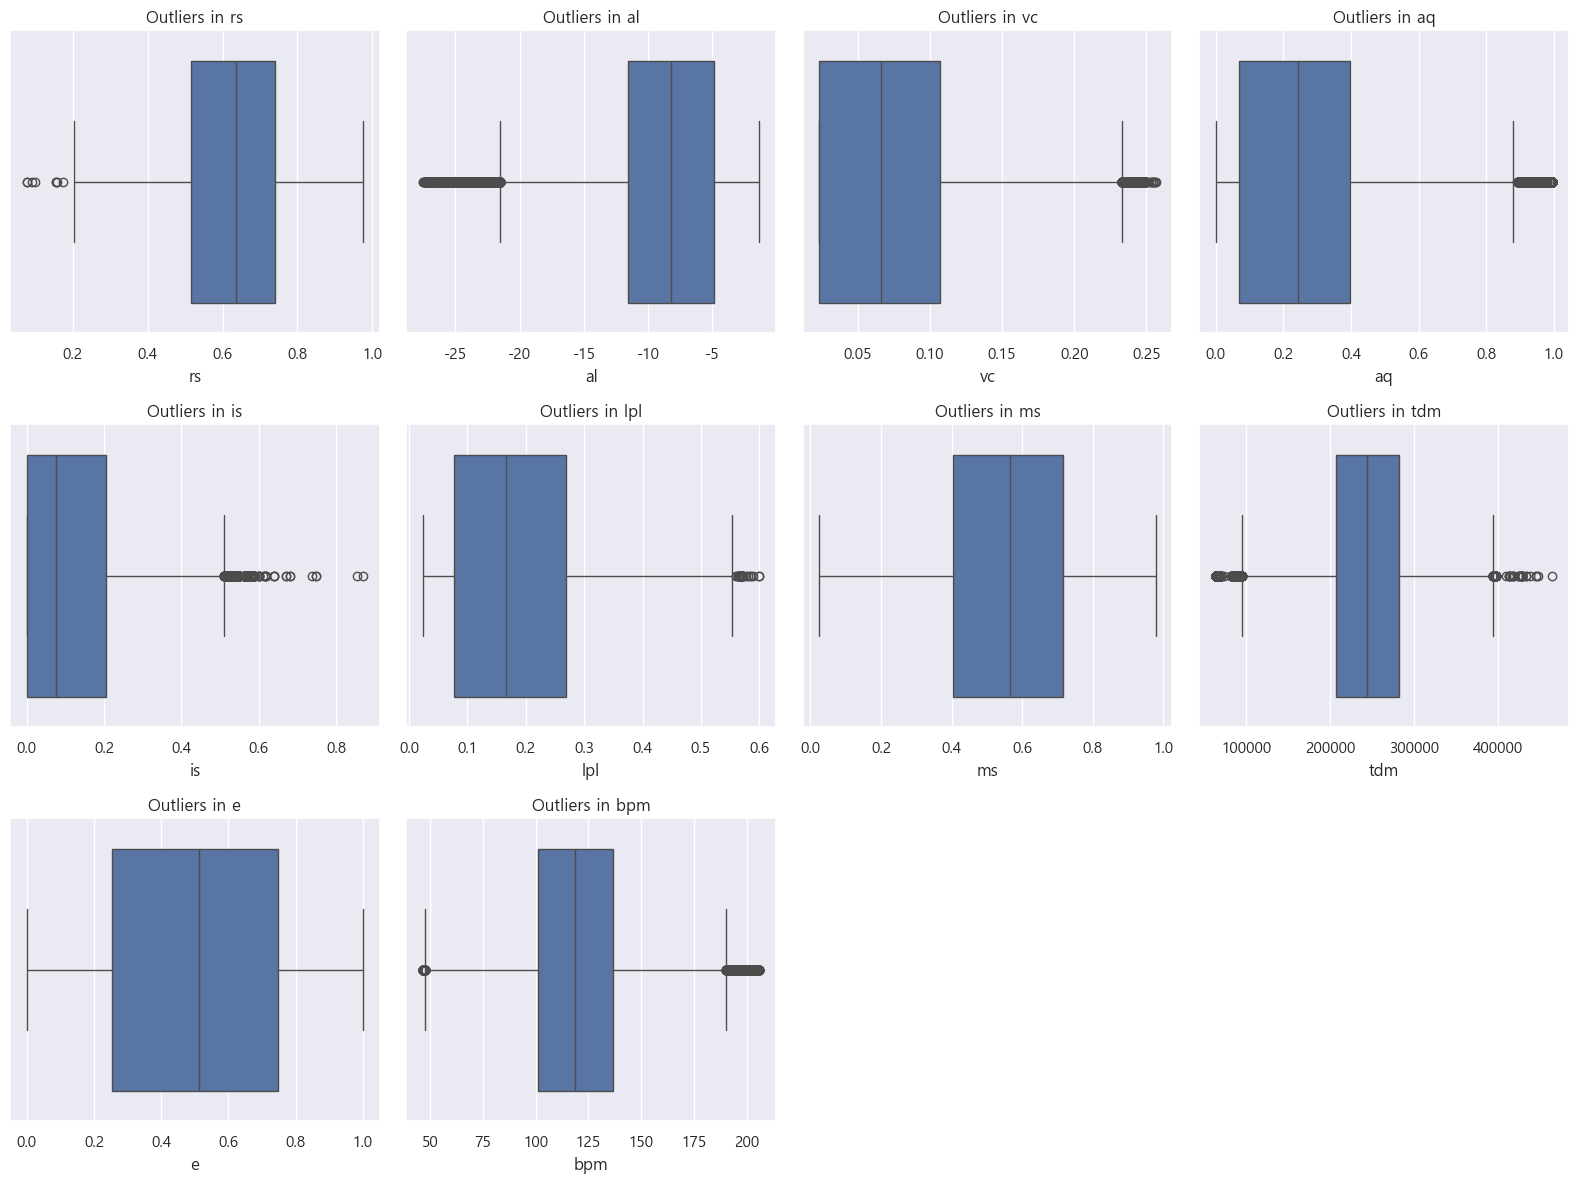

In [46]:
# 3x4 격자 형태의 서브플롯(그래프 틀) 생성
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten() # 2차원 배열의 axes를 1차원으로 변환하여 다루기 쉽게 함

# 데이터프레임의 각 열(column)에 대해 반복하여 박스 플롯(boxplot) 생성
for i, col in enumerate(df.columns):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"Outliers in {col}")

# 데이터프레임의 열 개수보다 서브플롯 개수가 많을 경우, 남는 플롯은 숨김 처리
for j in range(len(df.columns), len(axes)):
    axes[j].axis('off')

# 플롯 간 간격을 자동으로 조절하여 겹치지 않게 함
plt.tight_layout()

# 최종 그래프 출력
plt.show()

* 원본 데이터프레임을 따로 저장

In [47]:
dforg = df.copy()

# 일단 점수부터 보자

In [48]:
y = df['bpm']
X = df.drop('bpm', axis=1)
X80, X20, y80, y20 = train_test_split(X, y, test_size=0.2, random_state=8989)

model_list = [
    # DecisionTreeRegressor(random_state=8989),
    # RandomForestRegressor(random_state=8989),
    # GradientBoostingRegressor(random_state=8989),
    # SVR(),
    Ridge(random_state=8989),
    Lasso(random_state=8989),
    ElasticNet(random_state=8989),
    XGBRegressor(random_state=8989),
    LGBMRegressor(random_state=8989, verbosity=-1)
]

for i, model in enumerate(model_list):
    model.fit(X80, y80)
    pred = model.predict(X20)
    rmse = np.sqrt(mean_squared_error(y20, pred))
    print(f'{rmse:07.5f}  {model.__class__.__name__}')

38.34753  DecisionTreeRegressor
26.42411  Ridge
26.42585  Lasso
26.42585  ElasticNet
26.51690  XGBRegressor
26.42507  LGBMRegressor


## Validation Score

## Leaderboard Score

# 전처리 & 가공

## 이상치 처리 & 데이터 변환

### IQR

In [49]:
# 원본 데이터프레임을 복사하여 Trimming용 데이터프레임 'dft' 생성
dft = df.copy()

# 숫자형 특성(column)만 선택하여 리스트로 저장
num_features_for_trim = dft.select_dtypes(include=np.number).columns.tolist()

# Trimming 작업 시작 및 원본 데이터 형태(shape) 출력
print(">> Trimming Process Start")
print("Original Shape (dft):", dft.shape)

# 각 숫자형 특성에 대해 반복하여 이상치 제거 수행
for col in num_features_for_trim:
    # 사분위수(Q1, Q3) 및 사분위 범위(IQR) 계산
    Q1 = dft[col].quantile(0.25)
    Q3 = dft[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # IQR을 이용해 이상치 경계값(lower/upper bound) 설정
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 경계값을 벗어나는 행(row)을 데이터프레임에서 제거
    dft = dft[(dft[col] >= lower_bound) & (dft[col] <= upper_bound)]

# Trimming 완료 후 데이터 형태(shape) 출력
print("Trimmed Shape (dft):", dft.shape)

>> Trimming Process Start
Original Shape (dft): (524164, 10)
Trimmed Shape (dft): (505206, 10)


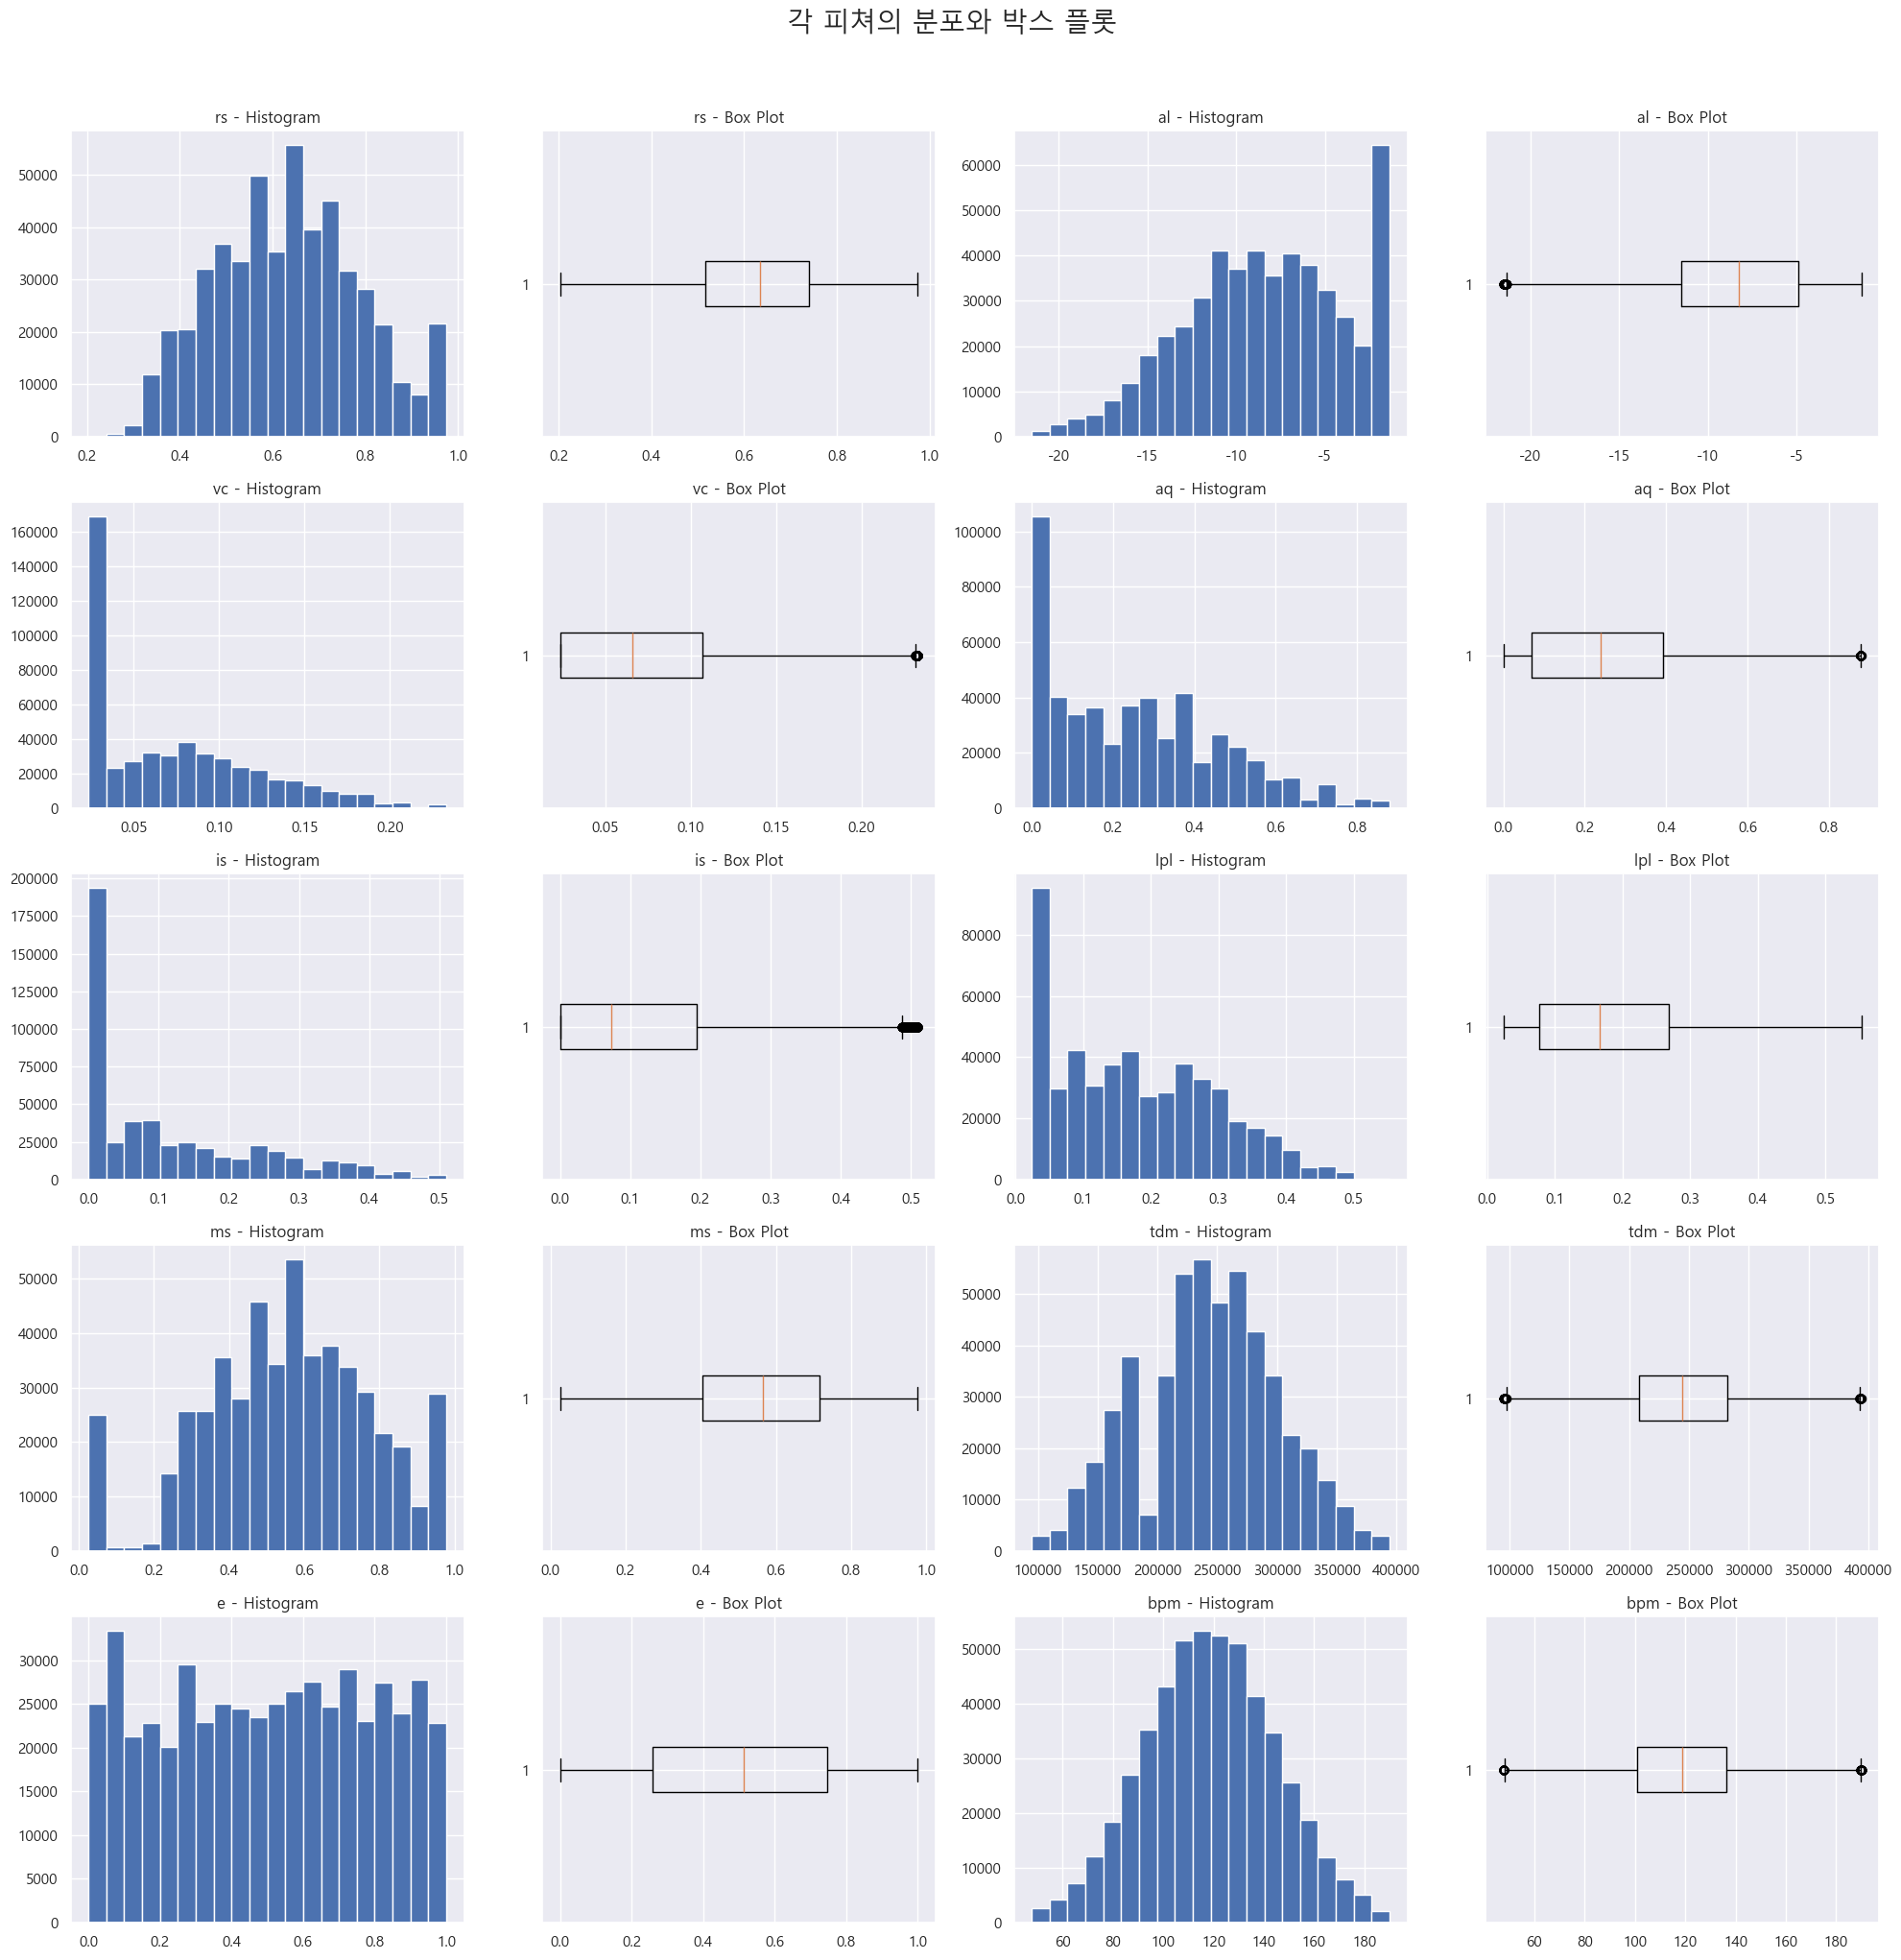

In [50]:
def histandbox(df):
    # --- 1. 시각화할 컬럼 목록 및 그리드 크기 계산 ---
    columns = df.columns
    num_columns = len(columns)
    
    # 한 행에 2개의 피쳐를 배치하므로, 총 행의 수는 (전체 컬럼 수 / 2)를 올림한 값입니다.
    num_rows = math.ceil(num_columns / 2)
    
    
    # --- 2. Subplot Grid 생성 (Matplotlib 기본 기능) ---
    # 5행 4열의 격자를 생성합니다.
    fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 4))
    
    fig.suptitle('각 피쳐의 분포와 박스 플롯', fontsize=20, y=1.02)
    
    
    # --- 3. 각 행을 순회하며 2개씩 플롯 그리기 ---
    for i in range(num_rows):
        # 현재 행에서 다룰 첫 번째 피쳐의 인덱스
        col1_idx = i * 2
        # 현재 행에서 다룰 두 번째 피쳐의 인덱스
        col2_idx = i * 2 + 1
    
        # --- 첫 번째 피쳐 그리기 (왼쪽 2개 열) ---
        if col1_idx < num_columns:
            col1_name = columns[col1_idx]
            
            # 왼쪽 첫 번째 칸: 히스토그램
            axes[i, 0].hist(df[col1_name], bins=20)
            axes[i, 0].set_title(f'{col1_name} - Histogram')
            
            # 왼쪽 두 번째 칸: 박스 플롯 (가로 방향으로)
            axes[i, 1].boxplot(df[col1_name], vert=False)
            axes[i, 1].set_title(f'{col1_name} - Box Plot')
    
        # --- 두 번째 피쳐 그리기 (오른쪽 2개 열) ---
        if col2_idx < num_columns:
            col2_name = columns[col2_idx]
            
            # 오른쪽 첫 번째 칸: 히스토그램
            axes[i, 2].hist(df[col2_name], bins=20)
            axes[i, 2].set_title(f'{col2_name} - Histogram')
            
            # 오른쪽 두 번째 칸: 박스 플롯 (가로 방향으로)
            axes[i, 3].boxplot(df[col2_name], vert=False)
            axes[i, 3].set_title(f'{col2_name} - Box Plot')
    
    # 피쳐 개수가 홀수일 경우, 마지막 행의 남는 공간들을 보이지 않게 처리
    if num_columns % 2 != 0 and num_rows > 0:
        axes[num_rows - 1, 2].axis('off')
        axes[num_rows - 1, 3].axis('off')
    
    # --- 4. 레이아웃 자동 조정 및 최종 그래프 출력 ---
    plt.tight_layout()
    plt.show()

histandbox(dft)

#### Validation Score

#### Leaderboard Score

### PowerTransformer

In [51]:
X = dforg.drop('bpm', axis=1)
y = dforg['bpm']

# 가장 먼저 데이터를 훈련용과 검증용으로 분할합니다.
X80, X20, y80, y20 = train_test_split(X, y, test_size=0.2, random_state=42)

# PowerTransformer 준비 및 적용
pt = PowerTransformer(method='yeo-johnson', standardize=True)

# 훈련 데이터(X80)에만 PowerTransformer를 학습(fit)시킵니다.
pt.fit(X80)

# 학습된 변환 규칙을 훈련 데이터와 검증 데이터 양쪽에 동일하게 적용(transform)합니다.
X80_transformed_np = pt.transform(X80)

# 변환된 데이터는 NumPy 배열이므로 다시 데이터프레임으로 만들어줍니다.
X80_transformed = pd.DataFrame(X80_transformed_np, columns=X80.columns, index=X80.index)

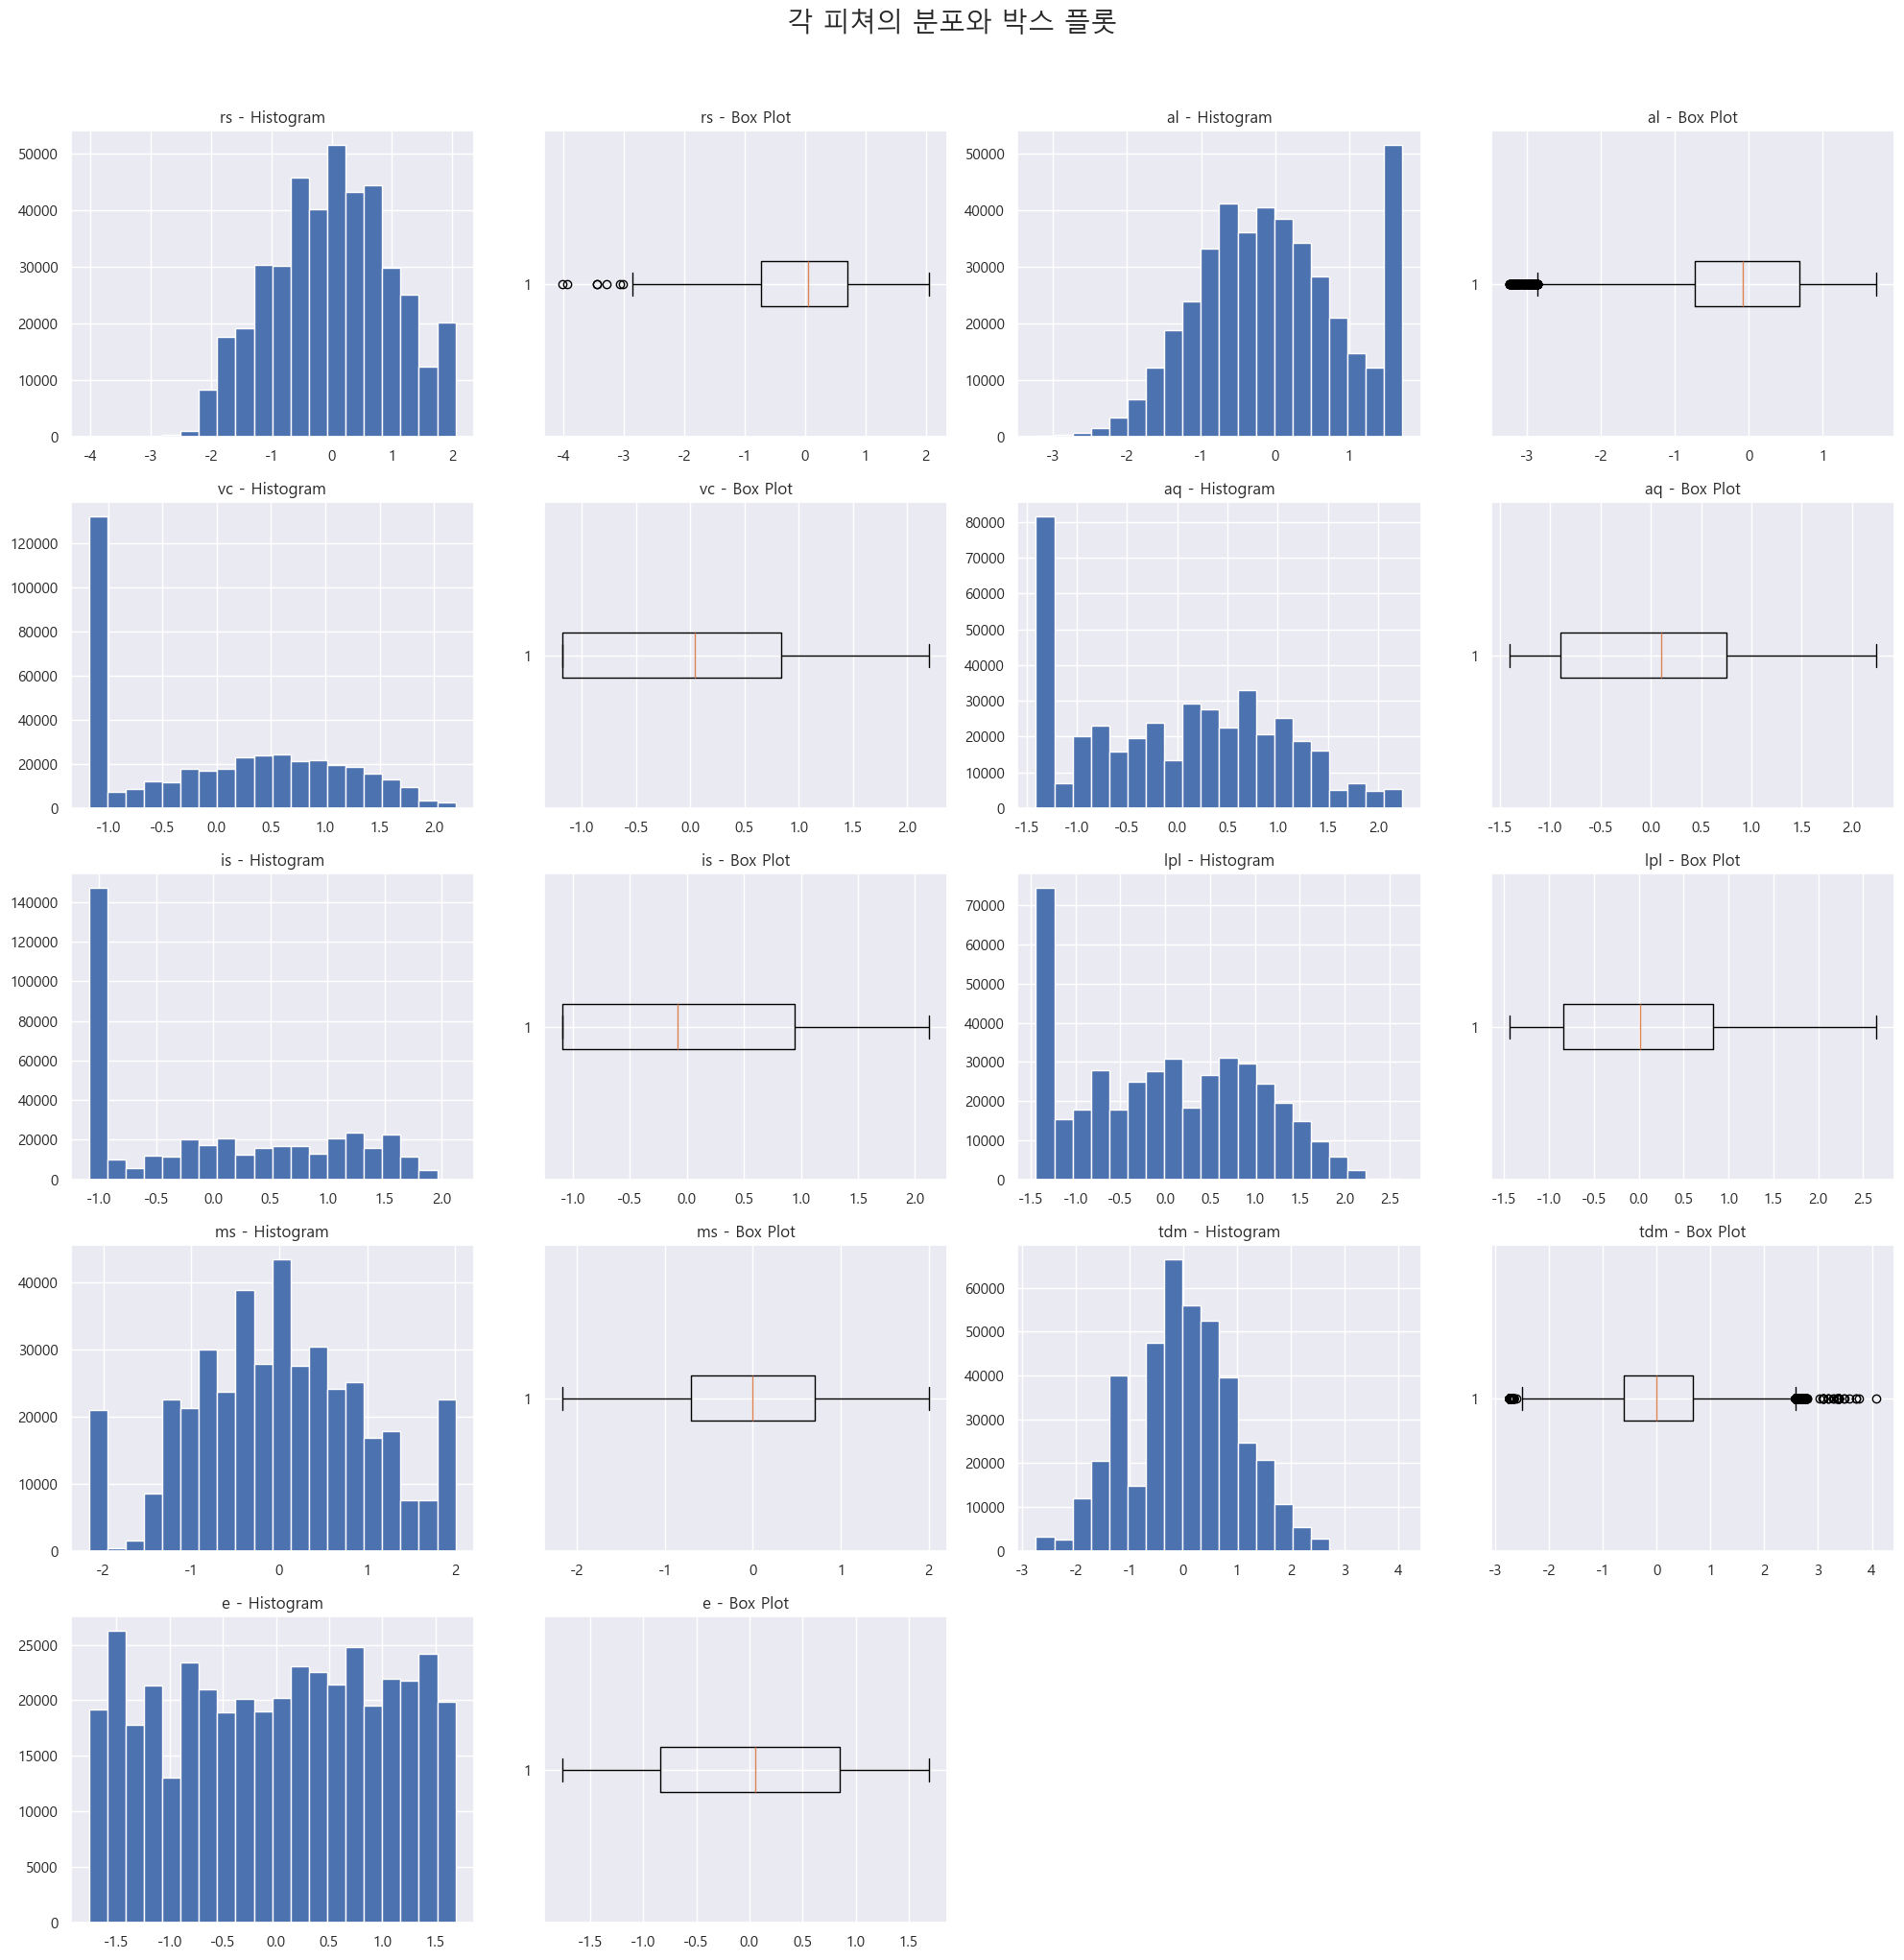

In [52]:
histandbox(X80_transformed)

#### Validation Score

#### Leaderboard Score

### IQR & PowerTransformer

In [53]:
X = dft.drop('bpm', axis=1)
y = dft['bpm']

# 가장 먼저 데이터를 훈련용과 검증용으로 분할합니다.
X80, X20, y80, y20 = train_test_split(X, y, test_size=0.2, random_state=42)

# PowerTransformer 준비 및 적용
pt = PowerTransformer(method='yeo-johnson', standardize=True)

# 훈련 데이터(X80)에만 PowerTransformer를 학습(fit)시킵니다.
pt.fit(X80)

# 학습된 변환 규칙을 훈련 데이터와 검증 데이터 양쪽에 동일하게 적용(transform)합니다.
X80_transformed_np = pt.transform(X80)

# 변환된 데이터는 NumPy 배열이므로 다시 데이터프레임으로 만들어줍니다.
X80_transformed = pd.DataFrame(X80_transformed_np, columns=X80.columns, index=X80.index)

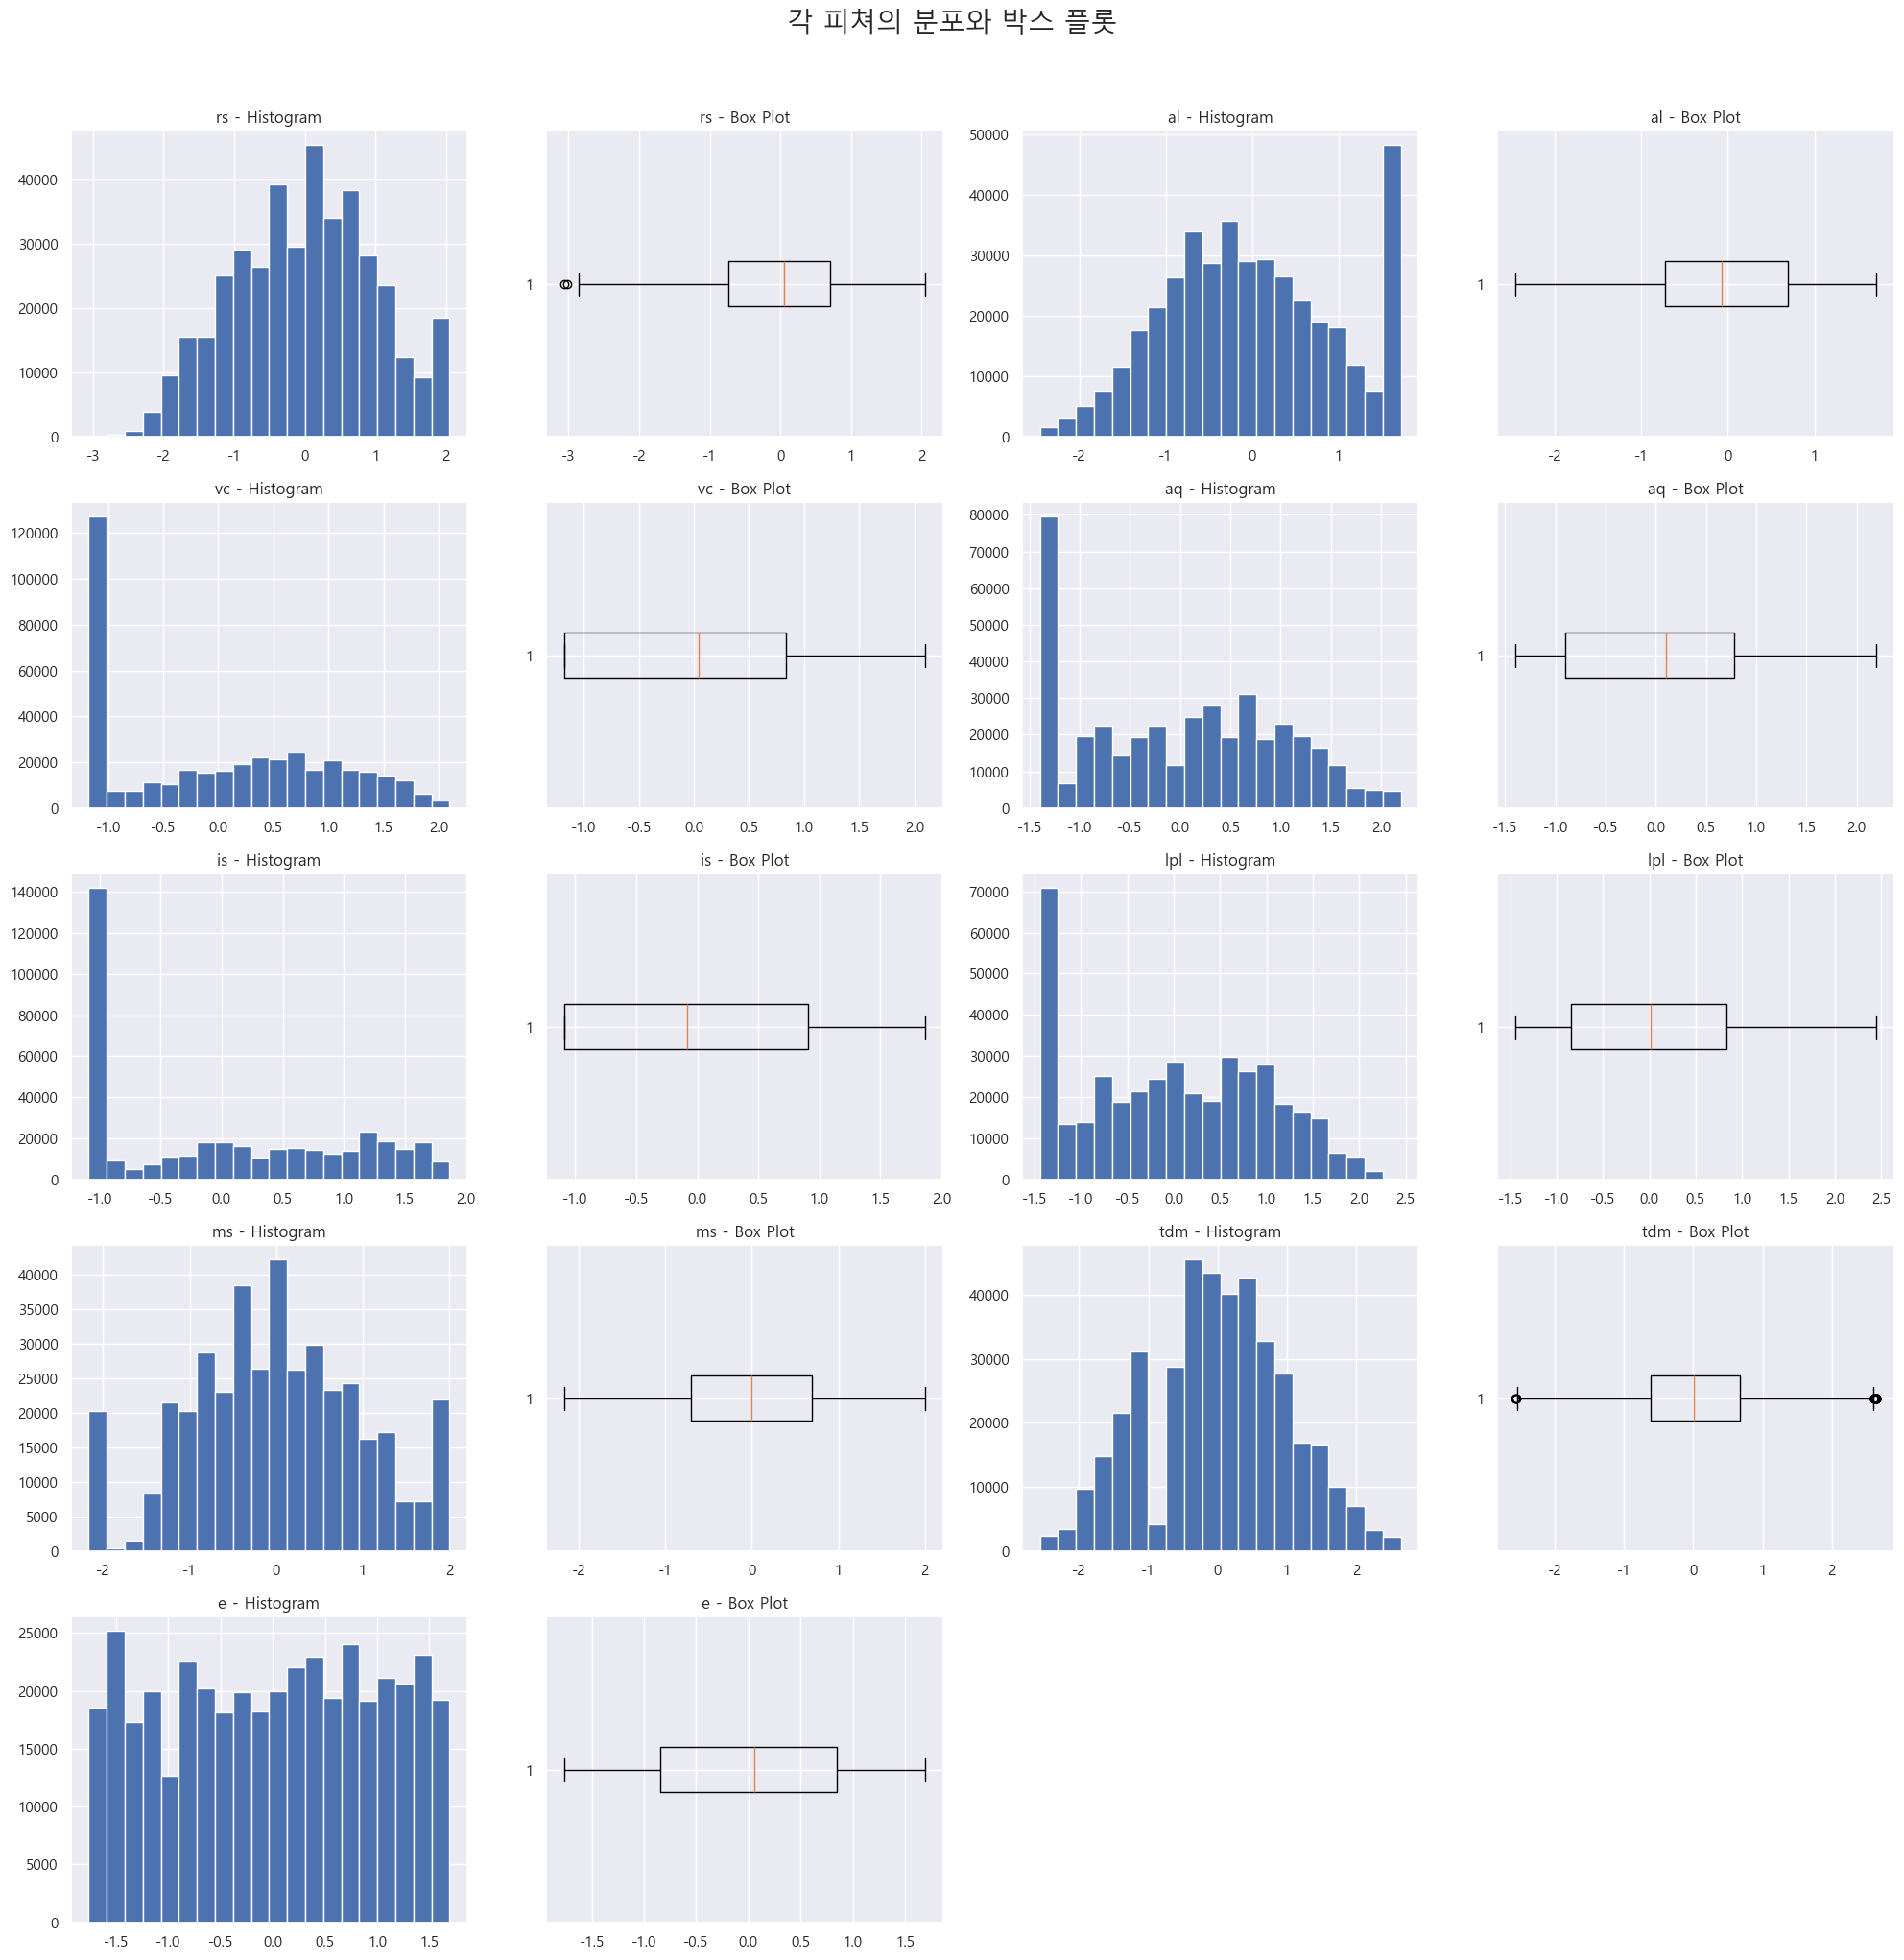

In [54]:
histandbox(X80_transformed)

#### Validation Score

#### Leaderboard Score

### IQR & 휴리스틱기반처리

In [130]:
dfh = dft.copy()

In [131]:
pd.cut(dfh['al'], bins=np.linspace(dfh['al'].min(), dfh['al'].max(), 11),
    include_lowest=True).value_counts().sort_index()

pd.cut(dfh['al'], bins=np.linspace(-2, dfh['al'].max(), 11),
    include_lowest=True).value_counts().sort_index()

dfh['al'][(dfh['al'] > -1.421) & (dfh['al'] <= -1.357)].value_counts()

al
-1.357000000    55626
-1.387581204       12
-1.372319461       11
-1.374209557       11
-1.405313906        9
                ...  
-1.410655873        1
-1.387581203        1
-1.372808383        1
-1.389613172        1
-1.387499887        1
Name: count, Length: 201, dtype: int64

In [132]:
print(f"삭제 전 데이터 개수: {len(dfh)}")
dfh = dfh[dfh['al'] != -1.357]
print(f"삭제 후 데이터 개수: {len(dfh)}")

삭제 전 데이터 개수: 505206
삭제 후 데이터 개수: 449580


In [133]:
pd.cut(dfh['vc'], bins=np.linspace(dfh['vc'].min(), dfh['vc'].max(), 11),
    include_lowest=True).value_counts().sort_index()

pd.cut(dfh['vc'], bins=np.linspace(dfh['vc'].min(), 0.0468, 11),
    include_lowest=True).value_counts().sort_index()

dfh['vc'][(dfh['vc'] > 0.0225) & (dfh['vc'] <= 0.0258)].value_counts()

vc
0.023500000    134971
0.024069787        27
0.024162234        24
0.024304320        24
0.024808284        24
                ...  
0.024652374         1
0.024254826         1
0.025559056         1
0.024656938         1
0.025681458         1
Name: count, Length: 1822, dtype: int64

In [134]:
print(f"삭제 전 데이터 개수: {len(dfh)}")
dfh = dfh[dfh['vc'] != 0.0235]
print(f"삭제 후 데이터 개수: {len(dfh)}")

삭제 전 데이터 개수: 449580
삭제 후 데이터 개수: 314609


In [135]:
pd.cut(dfh['aq'], bins=np.linspace(dfh['aq'].min(), dfh['aq'].max(), 11),
    include_lowest=True).value_counts().sort_index()

pd.cut(dfh['aq'], bins=np.linspace(dfh['aq'].min(), 0.088, 11),
    include_lowest=True).value_counts().sort_index()

dfh['aq'][(dfh['aq'] > -0.00099464) & (dfh['aq'] <= 0.0088)].value_counts()

aq
0.000005360    53624
0.004503487       61
0.001650837       53
0.001680010       47
0.001620302       28
               ...  
0.004507449        1
0.006037131        1
0.001177393        1
0.006712330        1
0.001836312        1
Name: count, Length: 1868, dtype: int64

In [136]:
print(f"삭제 전 데이터 개수: {len(dfh)}")
dfh = dfh[dfh['aq'] != 0.00000536]
print(f"삭제 후 데이터 개수: {len(dfh)}")

삭제 전 데이터 개수: 314609
삭제 후 데이터 개수: 260985


In [137]:
pd.cut(dfh['is'], bins=np.linspace(dfh['is'].min(), dfh['is'].max(), 11),
    include_lowest=True).value_counts().sort_index()

pd.cut(dfh['is'], bins=np.linspace(dfh['is'].min(), 0.051, 11),
    include_lowest=True).value_counts().sort_index()

dfh['is'][(dfh['is'] > -0.00099893) & (dfh['is'] <= 0.0051)].value_counts()

is
0.000001070    87720
0.002912533       45
0.002801874       42
0.004524417       40
0.003870526       38
               ...  
0.001658860        1
0.001276267        1
0.002869082        1
0.002921624        1
0.001639563        1
Name: count, Length: 1843, dtype: int64

In [138]:
print(f"삭제 전 데이터 개수: {len(dfh)}")
dfh = dfh[dfh['is'] != 0.00000107]
print(f"삭제 후 데이터 개수: {len(dfh)}")

삭제 전 데이터 개수: 260985
삭제 후 데이터 개수: 173265


In [139]:
pd.cut(dfh['lpl'], bins=np.linspace(dfh['lpl'].min(), dfh['lpl'].max(), 11),
    include_lowest=True).value_counts().sort_index()

pd.cut(dfh['lpl'], bins=np.linspace(dfh['lpl'].min(), 0.0764, 11),
    include_lowest=True).value_counts().sort_index()

dfh['lpl'][(dfh['lpl'] > 0.023299999999999998) & (dfh['lpl'] <= 0.0295)].value_counts()

lpl
0.024300000    39844
0.028837322        9
0.027820245        8
0.024975912        8
0.024918434        7
               ...  
0.026537016        1
0.024940096        1
0.027960704        1
0.027837479        1
0.027960395        1
Name: count, Length: 245, dtype: int64

In [140]:
print(f"삭제 전 데이터 개수: {len(dfh)}")
dfh = dfh[dfh['lpl'] != 0.0243]
print(f"삭제 후 데이터 개수: {len(dfh)}")

삭제 전 데이터 개수: 173265
삭제 후 데이터 개수: 133421


In [141]:
pd.cut(dfh['ms'], bins=np.linspace(dfh['ms'].min(), dfh['ms'].max(), 11),
    include_lowest=True).value_counts().sort_index()

pd.cut(dfh['ms'], bins=np.linspace(dfh['ms'].min(), 0.121, 11),
    include_lowest=True).value_counts().sort_index()
pd.cut(dfh['ms'], bins=np.linspace(0.883, dfh['ms'].max(), 11),
    include_lowest=True).value_counts().sort_index()

dfh['ms'][(dfh['ms'] > 0.0246) & (dfh['ms'] <= 0.0351)].value_counts()
dfh['ms'][(dfh['ms'] > 0.968) & (dfh['ms'] <= 0.978)].value_counts()

ms
0.978000000    10366
0.977428339       19
0.974179331       16
0.977350663       13
0.977122040        8
               ...  
0.976264782        1
0.974609938        1
0.976453682        1
0.977338578        1
0.974155555        1
Name: count, Length: 140, dtype: int64

In [142]:
print(f"삭제 전 데이터 개수: {len(dfh)}")
dfh = dfh[(dfh['ms'] != 0.0256) & (dfh['ms'] != 0.978)]
print(f"삭제 후 데이터 개수: {len(dfh)}")

삭제 전 데이터 개수: 133421
삭제 후 데이터 개수: 116034


In [143]:
pd.cut(dfh['tdm'], bins=np.linspace(dfh['tdm'].min(), dfh['tdm'].max(), 11),
    include_lowest=True).value_counts().sort_index()

pd.cut(dfh['tdm'], bins=np.linspace(184934.978, 214772.332, 11),
    include_lowest=True).value_counts().sort_index()

tdm
(184934.977, 187918.713]    1087
(187918.713, 190902.449]     139
(190902.449, 193886.184]       0
(193886.184, 196869.92]        1
(196869.92, 199853.655]       20
(199853.655, 202837.39]      340
(202837.39, 205821.126]     1723
(205821.126, 208804.861]    1632
(208804.861, 211788.597]    1863
(211788.597, 214772.332]    1485
Name: count, dtype: int64

In [144]:
# SMOTER나 노이즈 추가로 tdm 피쳐 불균형 해결?

In [1]:
# train과 test 분포를 비교해보고 둘이 비슷한 양상이면 휴리스틱 기반 처리 필요없음

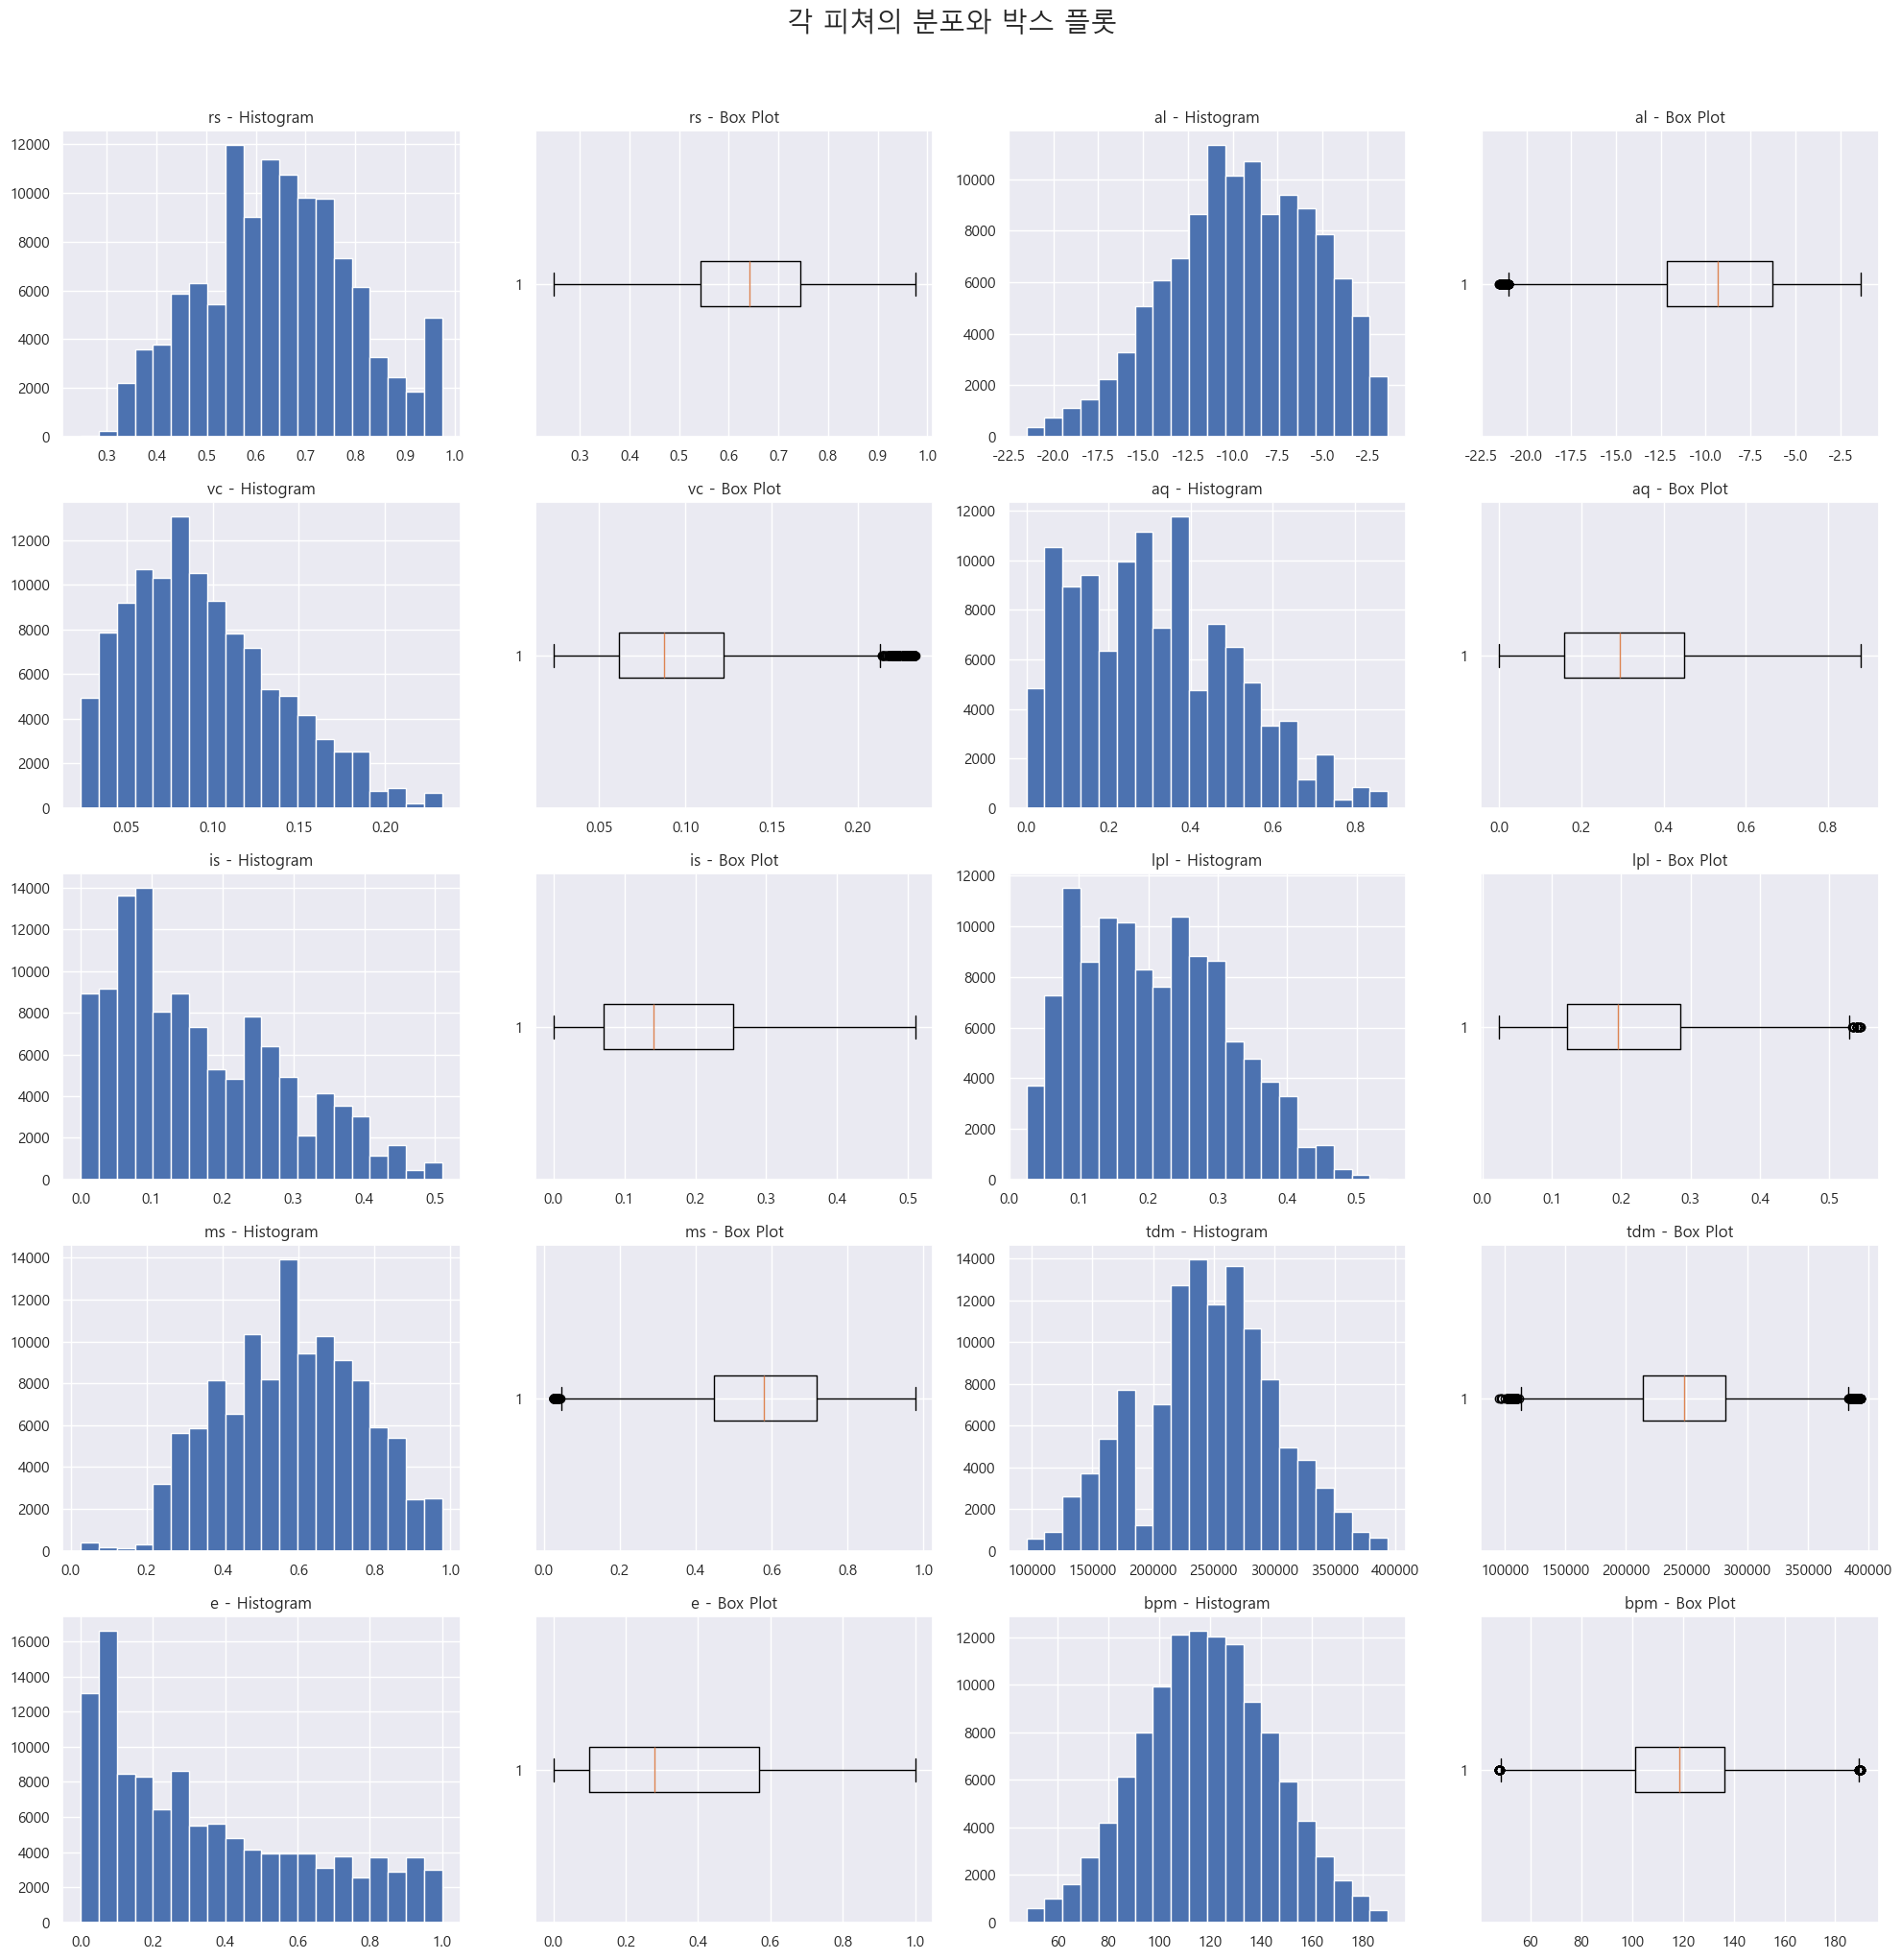

In [145]:
histandbox(dfh)

#### Validation Score

In [147]:
y = dfh['bpm']
X = dfh.drop('bpm', axis=1)
X80, X20, y80, y20 = train_test_split(X, y, test_size=0.2, random_state=8989)

model_list = [
    Ridge(random_state=8989),
    Lasso(random_state=8989),
    ElasticNet(random_state=8989),
    XGBRegressor(random_state=8989),
    LGBMRegressor(random_state=8989, verbosity=-1)
]

for i, model in enumerate(model_list):
    model.fit(X80, y80)
    pred = model.predict(X20)
    rmse = np.sqrt(mean_squared_error(y20, pred))
    print(f'{rmse:07.5f}  {model.__class__.__name__}')

25.92484  Ridge
25.92763  Lasso
25.92758  ElasticNet
26.32032  XGBRegressor
25.94789  LGBMRegressor


#### Leaderboard Score

## 파생 피쳐 추가

### 기존 피쳐

In [149]:
dfh.columns

Index(['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e', 'bpm'], dtype='object')

#### Validation Score

#### Leaderboard Score

### 기존 피쳐 & 파생 피쳐

In [150]:
dfaf = dfh.copy()

dfaf['tdn'] = dfaf['tdm'] / 60000
dfaf['ear'] = dfaf['e'] / (dfaf['aq'] + 1e-5)
dfaf['vib'] = dfaf['vc'] / (dfaf['is'] + 1e-5)
dfaf['mr'] = dfaf['ms'] * dfaf['rs']
dfaf['pi'] = dfaf['lpl'] * dfaf['al']
dfaf['re'] = dfaf['rs'] * dfaf['e']
dfaf['ma'] = dfaf['ms'] * dfaf['aq']

dfaf.columns

Index(['rs', 'al', 'vc', 'aq', 'is', 'lpl', 'ms', 'tdm', 'e', 'bpm', 'tdn',
       'ear', 'vib', 'mr', 'pi', 're', 'ma'],
      dtype='object')

#### Validation Score

#### Leaderboard Score

### Only 파생 피쳐

In [152]:
dfof = dfaf.drop(dfh.columns, axis=1)
dfof.columns

Index(['tdn', 'ear', 'vib', 'mr', 'pi', 're', 'ma'], dtype='object')

#### Validation Score

#### Leaderboard Score

## 피쳐 셀렉션

### shap

In [153]:
# # Jupyter Notebook/Lab 환경에서 SHAP 그래프를 예쁘게 보여주기 위해 초기화합니다.
# shap.initjs()

# # --- 1. 데이터 준비 및 분할 ---
# # 원본 데이터프레임(dforg)을 사용합니다.
# X = dforg.drop('bpm', axis=1)
# y = dforg['bpm']

# # 훈련용과 검증용으로 데이터를 분할합니다.
# X80, X20, y80, y20 = train_test_split(X, y, test_size=0.2, random_state=8989)


# # --- 2. 모델 학습 및 RMSE 계산 ---
# model = XGBRegressor(random_state=8989)
# model.fit(X80, y80)

# # 검증 데이터로 예측을 수행합니다.
# predictions = model.predict(X20)

# # 먼저 모델의 RMSE 점수를 계산하여 성능을 확인합니다.
# rmse = root_mean_squared_error(y20, predictions)
# print(f"XGBoost 모델의 RMSE: {rmse:.5f}")
# print("-" * 50)


# # --- 3. SHAP을 이용한 오차 분석 ---
# # Explainer 객체를 생성하고 SHAP 값을 계산합니다.
# explainer = shap.Explainer(model)
# shap_values = explainer(X20)

# # 예측 오차(잔차)를 계산합니다.
# errors = y20 - predictions

# # 오차가 가장 컸던 예측(절댓값 기준)의 인덱스를 찾습니다.
# worst_prediction_index = np.argmax(np.abs(errors))

# print(f"가장 큰 오차를 보인 샘플(인덱스: {worst_prediction_index}) 분석:")
# print(f"실제 BPM: {y20.iloc[worst_prediction_index]:.2f}")
# print(f"예측 BPM: {predictions[worst_prediction_index]:.2f}")
# print(f"오차: {errors.iloc[worst_prediction_index]:.2f}")


# # --- 4. 오차가 가장 컸던 예측에 대한 Force Plot 시각화 ---
# # 이 그래프를 통해 모델이 왜 예측을 크게 빗나갔는지 확인할 수 있습니다.
# shap.plots.force(shap_values[worst_prediction_index])

#### Validation Score

#### Leaderboard Score

### SelectFromModel

In [154]:
# # 1. df 복사본 생성
# dffs = df.copy()

# # 2. 타깃과 피처 분리
# y = dffs['bpm']
# X = dffs.drop('bpm', axis=1)

# # 3. Ridge 기반 Feature Selection
# selector = SelectFromModel(
#     estimator=Ridge(alpha=1.0),
#     threshold='median'   # 중요도가 중앙값 이상인 피처만 선택
# )

# selector.fit(X, y)

# # 4. 선택된 피처 이름 확인
# selected_features_mask = selector.get_support()
# selected_features = X.columns[selected_features_mask]

# print(f"총 {len(X.columns)}개 중 {len(selected_features)}개 피처 선택됨")
# print("\n[선택된 피처 목록]")
# print(list(selected_features))

# # 5. 선택된 피처로 dffs 갱신 (bpm 포함)
# dffs = dffs[['bpm'] + list(selected_features)]

# print(f"\n갱신된 dffs 형태: {dffs.shape}")

#### Validation Score

#### Leaderboard Score

## 인코딩

### LabelEncoding

#### Validation Score

#### Leaderboard Score

### One-Hot Encoding

#### Validation Score

#### Leaderboard Score

## 다중공선 처리

### Feature Drop

#### Validation Score

#### Leaderboard Score

### PCA

#### Validation Score

#### Leaderboard Score

## 스케일링

### log

#### Validation Score

#### Leaderboard Score

### Scaler

#### Validation Score

#### Leaderboard Score

### log & Scaler

#### Validation Score

#### Leaderboard Score

## 기본 모델로 점수 보기

### Validation Score

### Leaderboard Score

## 튜닝

## 교차 검증

### 규제

## 앙상블

### 보팅

### 배깅

### 스태킹